# Logistic Regression

Despite the name, logistic regression is actually a method for performing classification. A good starting point is to imagine a binary classification task in which items are classified in accordance with a single parameter value. To use another example from Coursera, consider a classifier that predicts whether a tumour is benign or malignant based on its size. We could use a perceptron to try to find a decision boundary between the two classes, but this would only work if the classes are linearly seperable. In the context of the example under consideration, linear seperability would require that every benign tumour is strictly larger (or strictly smaller) than every malignant tumour. Such an assumption is unlikely to hold in practice, so we want a method to find the best linear decision boundary, even if it isn't perfect. Logistic regression can be used to solve this problem. 

To visualize things, we'll use the example of predicting whether a student gets into a particular university based on their score on two entrance exams. Here's the data.

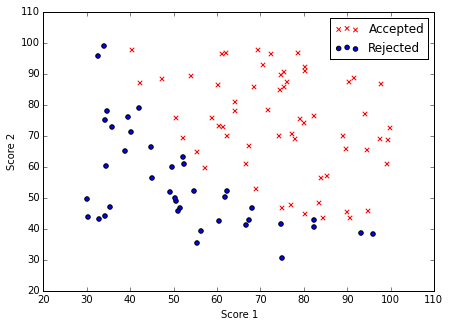

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt('/Users/peterblouw/git/stat-946/data/logistic1.txt', delimiter=',')
accepts = data[data[:,2] == 1]
rejects = data[data[:,2] == 0]

plt.figure(figsize=(7,5))
plt.scatter(accepts[:,0], accepts[:,1], marker='x', c='r')
plt.scatter(rejects[:,0], rejects[:,1], marker='o', c='b')
plt.legend(['Accepted','Rejected'])
plt.xlabel('Score 1')
plt.ylabel('Score 2')
plt.show()

The goal of the learning procedure is to assign a probability to the hypothesis that a student was accepted. To do this, we map a linear combination of the exam scores onto a probability value using the logistic (or sigmoid) function, which is defined as:

$sigmoid(z) = \frac{1}{1+e^{-z}}$

For very large positive values of $z$, the value of the function asymptotically approaches 1, while for very large negative values of $z$, the value of the function asymptotically approaches 0. At $z=0$ the value of the function is 0.5. Since $z=\theta^t x$, the aim is to find a set of parameters $\theta$ that map all positive examples to $z >= 0.5$ and all negative examples to $z < 0.5$. 

The cost function for this objective is defined to strongly penalize deviations from the target probabilities assigned to each training example. Specifically, the cost per example approaches infinity as the predicted probability approaches the complement of the target probability. The cost non-linearly approaches zero as the predicted probability approaches the target probability. Formally:

$J(\theta) = -\sum_{i=1}^{n} [y_i \cdot log(H(x_i)) + (1-y_i) \cdot log(1-H(x_i))]$

This is essentially a piecewise function defined seperately for each of the two possible target values. The gradient here is notationally similar to the gradient for linear regression (note: one ought to derive this gradient to ensure understanding):

$\nabla J(\theta) = \frac{1}{m} \sum_{i=1}^{n} (H(x_i) - y_i)\cdot x_i$

We iteratively update $\theta$ by applying a learning rate to this gradient, and stop once the iteration starts to converge. Here's an implementation.

In [2]:
n = len(data)
theta = np.random.randn(3)

# Put data into arrays 
bias = np.ones(n).reshape(n,1)
samples = np.hstack((bias, data[:,:2]))
targets = data[:,2]

# Perform feature normalization 
factor = np.max(samples, axis=0)
samples = samples / np.max(samples, axis=0)

# Define functions used in the algorithm
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def cost(theta, s, t):
    predict = sigmoid(np.dot(s, theta))
    costs = -t*np.log(predict) - (1-t)*np.log(1-predict)
    return costs.mean()

def grad(theta, s, t):
    error = sigmoid(np.dot(s, theta)) - t
    gradient = sum(s * error.reshape(s.shape[0],1)) / s.shape[0]
    return gradient

# Perform gradient descent using BFGS for nice results
from scipy import optimize

theta = optimize.fmin_bfgs(cost, theta, fprime=grad, args=(samples, targets))

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31


Now, it is possible to plot the decision boundary corresponding to these learned parameters. Note that there is slight change to the scale of the plot due to the fact that we used feature normalization. 

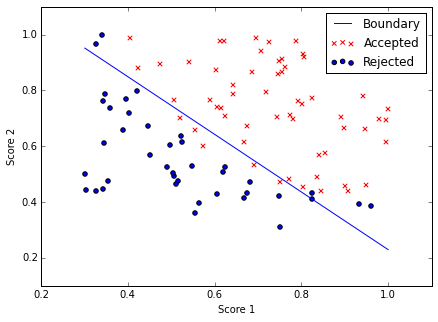

In [3]:
def plot_boundary(theta, samples):
    # Define two points on the decision boundary
    x = np.array([min(samples[:,1]), max(samples[:,1])])
    y = (-1./ theta[2]) * (theta[1] * x + theta[0])

    # Pull out the data corresponding to normalized exam scores
    samples = np.hstack((samples[:,1:], data[:,2].reshape(n,1)))
    accepts = samples[samples[:,2] == 1]
    rejects = samples[samples[:,2] == 0]

    # Plot the results
    plt.figure(figsize=(7,5))
    plt.scatter(accepts[:,0], accepts[:,1], marker='x', c='r')
    plt.scatter(rejects[:,0], rejects[:,1], marker='o', c='b')
    plt.plot(x,y)
    plt.legend(['Boundary','Accepted','Rejected'])
    plt.xlabel('Score 1')
    plt.ylabel('Score 2')
    plt.show()
    
plot_boundary(theta, samples)

# Comparison to Delta Rule with a Logistic Neuron

Just as it is possible to interpret multivariate linear regression as learning the weights on a linear neuron, it is also possible to interpret logistic regression as learning the weights on a sigmoidal neuron. Learning the weights on such a neuron is typically done using the delta rule, which involves computing the partial derivative of a cost function (squared error in this case) with respect a single weight. As before, we apply the chain rule:

$ \frac{\partial E}{\partial w_i} = \frac{dE}{dy} \frac{dy}{dz} \frac{\partial z}{\partial w_i}$

where $y$ is the output of the sigmoid unit, $z$ is its total input, and $w_i$ is the incoming weight on the $i^{th}$ connection. With squared error as our cost function, this derivative evaluates to:

$ \frac{\partial E}{\partial w_i} = -x_i \cdot y(1-y)(t-y)$

where $x_i$ is the input value passed through $w_i$ and $t$ is the target value of output. It is interesting to test whether there are any differences that arise when using this cost function and the cost function in our earlier example. Here's the result:

Optimization terminated successfully.
         Current function value: 3.225415
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37


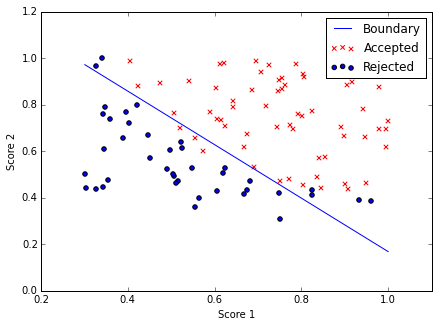

In [4]:
theta = np.random.randn(3) * 0.1

def nn_cost(theta, s, t):
    predict = sigmoid(np.dot(s, theta))
    costs = sum(np.square(t-predict))
    return costs.mean() / 2.0

def nn_grad(theta, s, t):
    predict = sigmoid(np.dot(s, theta))
    dz = -predict * (1 - predict) * (t - predict)
    gradient = sum(s * dz.reshape(s.shape[0],1)) / (2.0*n)
    return gradient

theta = optimize.fmin_bfgs(nn_cost, theta, fprime=nn_grad, args=(samples, targets))
plot_boundary(theta, samples)

This comparison indicates that, in this case at least, there is no significant difference that results from choosing different cost functions. It is a bit surprising that this is the case, since with a squared-error cost function and a sigmoid activation function, the gradient approaches zero as the difference between the predicted value on the output unit and actual value approaches one. (Recall that the slope of the sigmoid function moves towards zero as one moves towards positive or negative infinity). 